<a href="https://colab.research.google.com/github/sohaibasim46/Final-Year-Project-Sohaib/blob/main/Topic_06_jan_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis of Movie Customer Feedback**

# **Part 1: Importing Files**

In [1]:
import os
import tarfile
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# Style configuration for plots
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully.")

Libraries imported successfully.


## **Data Acquisition and Extraction**

In [2]:
# URL and file paths
dataset_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
file_name = "aclImdb_v1.tar.gz"
extracted_folder = "aclImdb"

def download_and_extract(url, save_path, extract_path):
    # Download
    if not os.path.exists(save_path):
        print(f"Downloading {save_path}...")
        response = requests.get(url, stream=True)
        with open(save_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
        print("Download complete.")
    else:
        print("File already exists. Skipping download.")

    # Extract
    if not os.path.exists(extract_path):
        print(f"Extracting {save_path}...")
        with tarfile.open(save_path, "r:gz") as tar:
            tar.extractall()
        print("Extraction complete.")
    else:
        print("Extracted folder already exists.")

download_and_extract(dataset_url, file_name, extracted_folder)

Download complete.
Extracting aclImdb_v1.tar.gz...


/tmp/ipython-input-3229853461.py:23: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Extraction complete.


## **Data Loading**

In [3]:
def load_imdb_data(base_path):
    data = []
    # The dataset is split into train and test folders
    for split in ['train', 'test']:
        for sentiment in ['pos', 'neg']:
            path = os.path.join(base_path, split, sentiment)
            if not os.path.exists(path):
                print(f"Warning: Path {path} does not exist.")
                continue

            print(f"Loading {split} - {sentiment}...")
            for file_name in os.listdir(path):
                if file_name.endswith('.txt'):
                    file_path = os.path.join(path, file_name)
                    with open(file_path, 'r', encoding='utf-8') as f:
                        review = f.read()
                        # Filenames are like "ID_Rating.txt"
                        rating = int(file_name.split('_')[1].split('.')[0])
                        data.append({
                            'review': review,
                            'sentiment': sentiment,
                            'split': split,
                            'rating': rating
                        })
    return pd.DataFrame(data)

# Load the data (This may take a minute)
df = load_imdb_data(extracted_folder)

# Convert sentiment to binary label (optional but good for ML later)
df['label'] = df['sentiment'].apply(lambda x: 1 if x == 'pos' else 0)

print(f"Data loaded. Shape: {df.shape}")
df.head()

Loading train - pos...
Loading train - neg...
Loading test - pos...
Loading test - neg...
Data loaded. Shape: (50000, 5)


,review,sentiment,split,rating,label
0,"This is one of those feel good, Saturday after...",pos,train,8,1
1,This is the best film version of Dicken's clas...,pos,train,10,1
2,I had the opportunity to see this film debut a...,pos,train,10,1
3,"Not sure one can call this an anti-war film, i...",pos,train,10,1
4,Armageddon PPV<br /><br />The last PPV of 2006...,pos,train,7,1


# **Exploratory Data Analysis & Cleaning**

## **Basic Inspection**

In [4]:
print("--- Dataset Info ---")
print(df.info())

print("\n--- Class Distribution ---")
print(df['sentiment'].value_counts())

print("\n--- Split Distribution ---")
print(df['split'].value_counts())

# Check for duplicates
duplicates = df.duplicated(subset=['review']).sum()
print(f"\nNumber of duplicate reviews: {duplicates}")

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
 2   split      50000 non-null  object
 3   rating     50000 non-null  int64 
 4   label      50000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.9+ MB
None

--- Class Distribution ---
sentiment
pos    25000
neg    25000
Name: count, dtype: int64

--- Split Distribution ---
split
train    25000
test     25000
Name: count, dtype: int64

Number of duplicate reviews: 418


## **Text Preprocessing for EDA**

In [5]:
def clean_text(text):
    # Remove HTML tags (e.g., <br />)
    text = re.sub(r'<br\s*/?>', ' ', text)
    # Remove non-alphabetic characters (optional, depending on depth of EDA)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

print("Cleaning reviews...")
df['clean_review'] = df['review'].apply(clean_text)
df.head()

Cleaning reviews...


,review,sentiment,split,rating,label,clean_review
0,"This is one of those feel good, Saturday after...",pos,train,8,1,this is one of those feel good saturday aftern...
1,This is the best film version of Dicken's clas...,pos,train,10,1,this is the best film version of dickens class...
2,I had the opportunity to see this film debut a...,pos,train,10,1,i had the opportunity to see this film debut a...
3,"Not sure one can call this an anti-war film, i...",pos,train,10,1,not sure one can call this an antiwar film it ...
4,Armageddon PPV<br /><br />The last PPV of 2006...,pos,train,7,1,armageddon ppv the last ppv of smackdown brand...


## **Feature Engineering**

In [6]:
# Word count
df['word_count'] = df['clean_review'].apply(lambda x: len(x.split()))

# Character count
df['char_count'] = df['clean_review'].apply(len)

# Average word length
df['avg_word_len'] = df['char_count'] / (df['word_count'] + 1)

print("Meta-features created.")
df[['sentiment', 'word_count', 'char_count', 'avg_word_len']].describe()

Meta-features created.


,word_count,char_count,avg_word_len
count,50000.000000,50000.000000,50000.000000
mean,226.852700,1241.017740,5.403371
std,168.178261,939.145489,0.321123
min,4.000000,30.000000,3.800000
25%,124.000000,664.000000,5.191176
50%,170.000000,920.000000,5.391140
75%,275.000000,1504.000000,5.600000
max,2450.000000,13271.000000,13.723404


## **Visualization - Review Length Distribution**

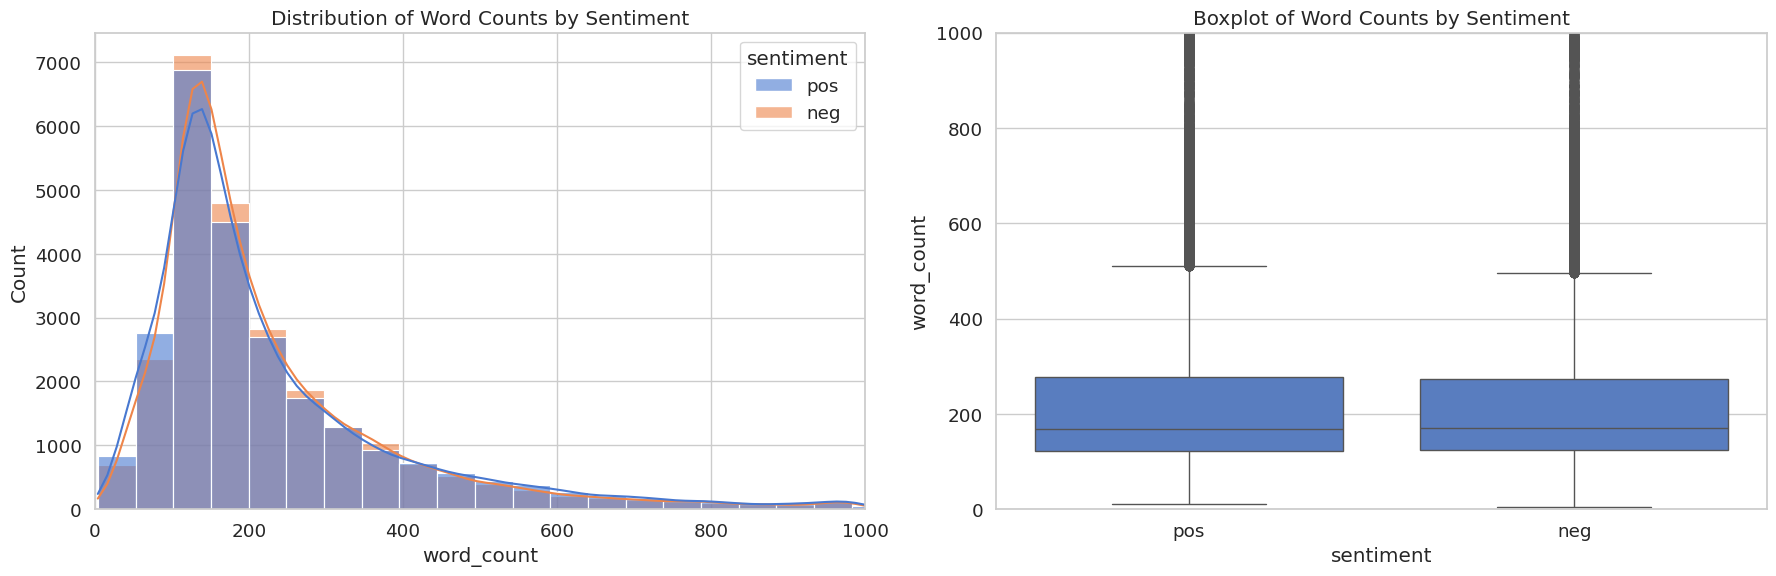

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histogram of Word Counts
sns.histplot(data=df, x='word_count', hue='sentiment', kde=True, bins=50, ax=axes[0], alpha=0.6)
axes[0].set_title('Distribution of Word Counts by Sentiment')
axes[0].set_xlim(0, 1000)  # Limit x-axis to focus on the bulk of data

# Boxplot for Word Counts
sns.boxplot(data=df, x='sentiment', y='word_count', ax=axes[1])
axes[1].set_title('Boxplot of Word Counts by Sentiment')
axes[1].set_ylim(0, 1000)

plt.tight_layout()
plt.show()

## **N-gram Analysis**

/tmp/ipython-input-2418286019.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(y_pos), y=list(x_pos), ax=axes[0], palette='Greens_r')
/tmp/ipython-input-2418286019.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(y_neg), y=list(x_neg), ax=axes[1], palette='Reds_r')


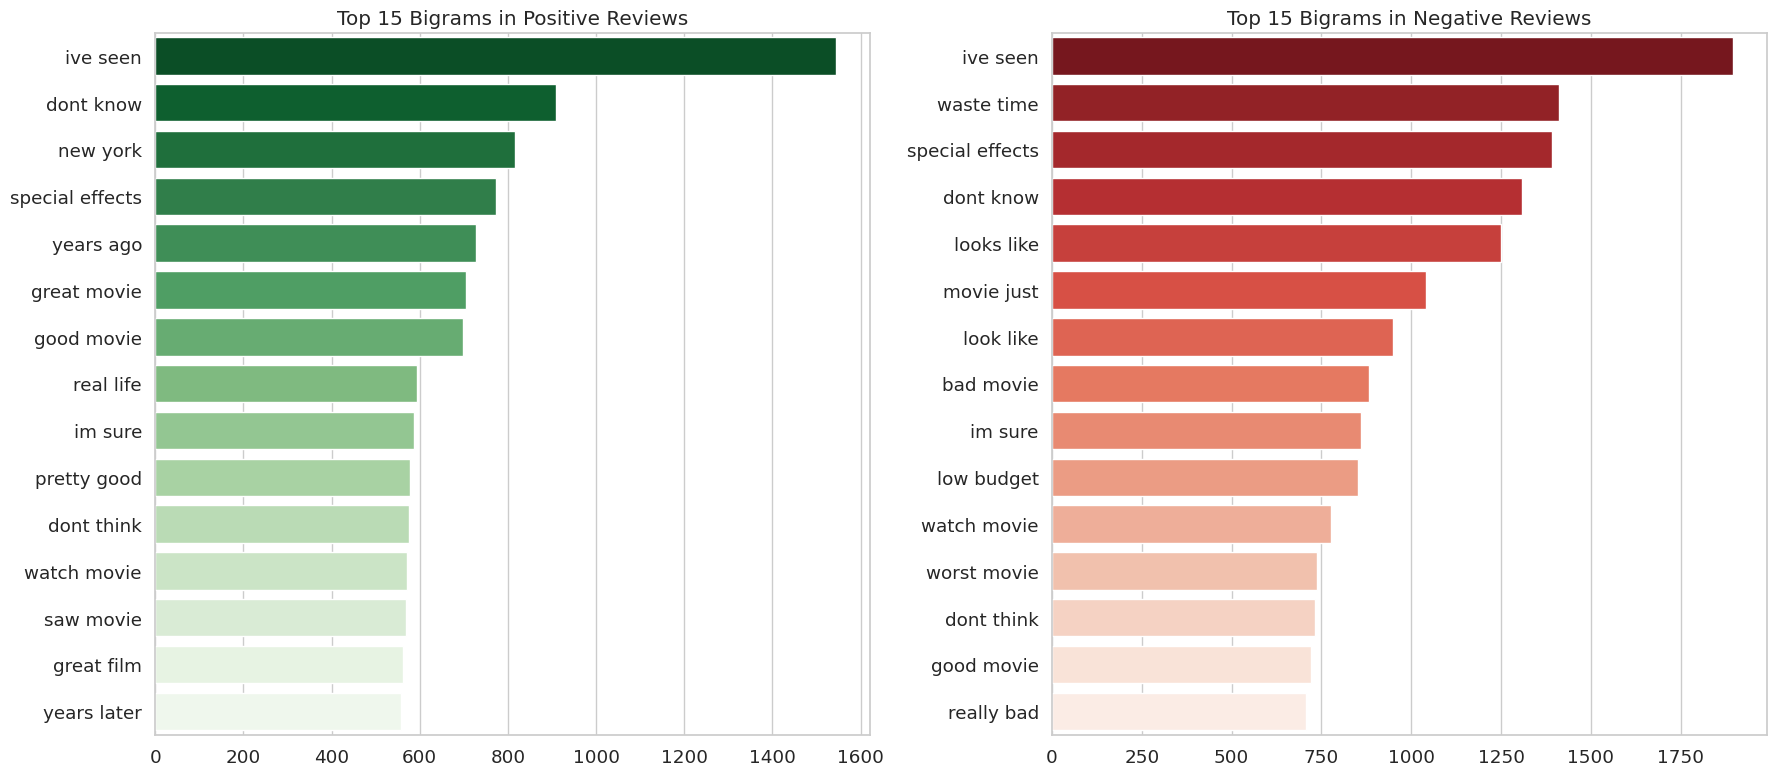

In [8]:
def get_top_ngrams(corpus, n=1, top_k=20):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_k]

# Separate corpora
pos_text = df[df['sentiment'] == 'pos']['clean_review']
neg_text = df[df['sentiment'] == 'neg']['clean_review']

# Get top bigrams (2-word phrases)
top_bigrams_pos = get_top_ngrams(pos_text, n=2, top_k=15)
top_bigrams_neg = get_top_ngrams(neg_text, n=2, top_k=15)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Positive Bigrams
x_pos, y_pos = zip(*top_bigrams_pos)
sns.barplot(x=list(y_pos), y=list(x_pos), ax=axes[0], palette='Greens_r')
axes[0].set_title('Top 15 Bigrams in Positive Reviews')

# Negative Bigrams
x_neg, y_neg = zip(*top_bigrams_neg)
sns.barplot(x=list(y_neg), y=list(x_neg), ax=axes[1], palette='Reds_r')
axes[1].set_title('Top 15 Bigrams in Negative Reviews')

plt.tight_layout()
plt.show()

## **Word Clouds**

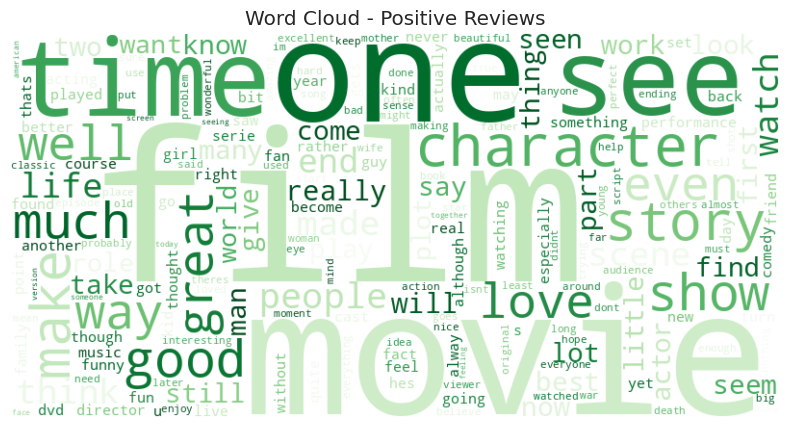

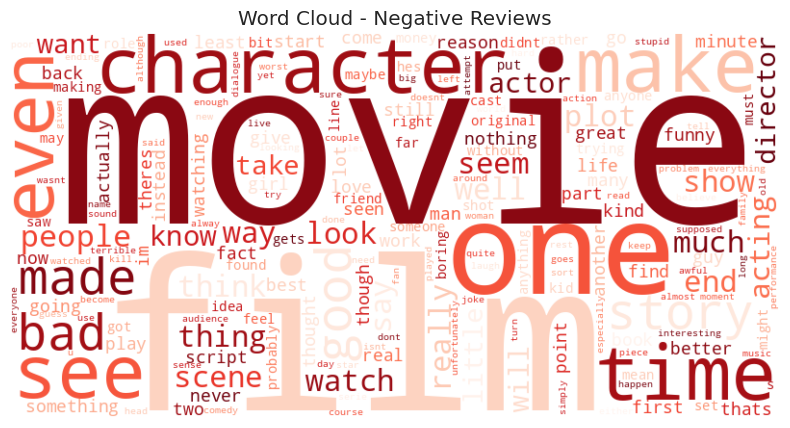

In [9]:
def plot_wordcloud(text, title, cmap='viridis'):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=cmap).generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Positive Word Cloud
plot_wordcloud(pos_text, "Word Cloud - Positive Reviews", cmap='Greens')

# Negative Word Cloud
plot_wordcloud(neg_text, "Word Cloud - Negative Reviews", cmap='Reds')

## **Rating vs Sentiment Check (Sanity Check)**

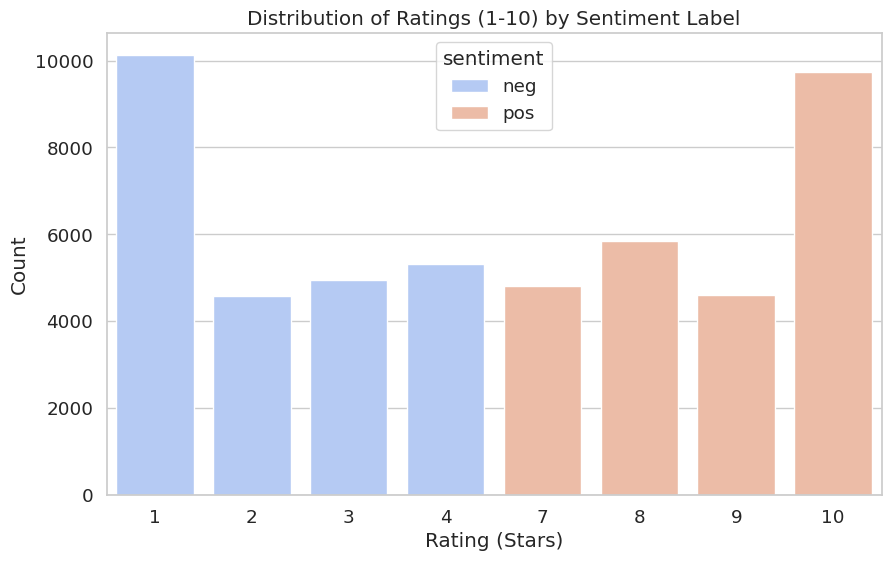

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='rating', hue='sentiment', palette='coolwarm')
plt.title('Distribution of Ratings (1-10) by Sentiment Label')
plt.xlabel('Rating (Stars)')
plt.ylabel('Count')
plt.show()

# Insight:
# Ratings 1-4 should be purely Negative.
# Ratings 7-10 should be purely Positive.
# Ratings 5-6 are usually excluded in this dataset (neutral).